In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
acc_s = "Accuracy"  # "Точность"
tot_acc = "Total accuracy"  # "Полная точность"
num_tasks = "Number of tasks" # "Число задач"
lambda_s = "hyperparameter " + r"$\lambda$"  # "Лямбда"
interval_s = "confidence interval"  # "доверительный интервал"
mean_s = "mean value"  # "среднее"

**1. Убеждаемся, что для SGD применение ослабления к градиентам и дельтам абсолютно эквивалентны**

In [3]:
data1 = joblib.load('wva-sgd-1x-grads.dmp')
data2 = joblib.load('wva-sgd-1x-deltas.dmp')

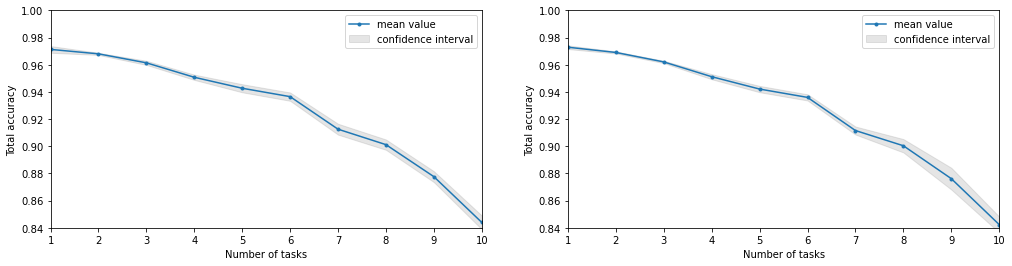

In [4]:
lmbda = 450.
means1 = np.mean(data1[lmbda], axis=0)
intervals1 = np.std(data1[lmbda], axis=0) * 2.2622 / np.sqrt(10)
means2 = np.mean(data2[lmbda], axis=0)
intervals2 = np.std(data2[lmbda], axis=0) * 2.2622 / np.sqrt(10)
x = range(1, len(means1) + 1)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(17, 4)
)
for ax, means, intervals in zip((ax1, ax2), (means1, means2), (intervals1, intervals2)):
    ax.set_ylim(0.84, 1.)
    ax.set_xlim(min(x), max(x))
    ax.set_ylabel(tot_acc)
    ax.set_xlabel(num_tasks)
    ax.fill_between(x, means-intervals, means+intervals, color='grey', alpha=.2, label=interval_s)
    ax.plot(x, means, marker=".", label=mean_s)
# ax1.set_title(f'Mean accuracy degradation while continual learning on {len(means2)} datasets\n'
#               f'with lambda {lmbda} using SGD with gradient attenuation')
# ax2.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#               f'with lambda {lmbda} using SGD with opt-step attenuation')
#ax1.text(x = 7.2, y = 0.96, s = f'SGD, lambda {lmbda}\n''gradient attenuation')
#ax2.text(x = 7.2, y = 0.96, s = f'SGD, lambda {lmbda}\n''opt-step attenuation')
ax1.legend()
ax2.legend()
plt.savefig('fig3eng.png', dpi = 600)
plt.show()

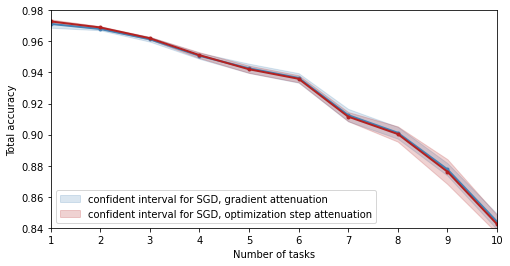

In [5]:
label1 = 'confident interval for SGD, gradient attenuation'
label2 = 'confident interval for SGD, optimization step attenuation'
lmbda = 450.
means1 = np.mean(data1[lmbda], axis=0)
intervals1 = np.std(data1[lmbda], axis=0) * 2.2622 / np.sqrt(10)
means2 = np.mean(data2[lmbda], axis=0)
intervals2 = np.std(data2[lmbda], axis=0) * 2.2622 / np.sqrt(10)
x = range(1, len(means1) + 1)

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(8, 4)
)
ax.set_ylim(0.84, 0.98)
ax.set_xlim(min(x), max(x))
ax.set_ylabel(tot_acc)
ax.set_xlabel(num_tasks)
ax.fill_between(x, means1-intervals1, means1+intervals1, color='steelblue', alpha=.2, label=label1)
ax.plot(x, means1, color = 'steelblue', marker=".", linewidth = 2)
ax.fill_between(x, means2-intervals2, means2+intervals2, color='firebrick', alpha=.2, label=label2)
ax.plot(x, means2, color = 'firebrick', marker=".", linewidth = 2)
plt.legend()
# ax.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#                f'with lambda {lmbda} using SGD', fontsize = 18)
plt.savefig('fig3_single_eng.png', dpi = 600)
plt.show()

In [6]:
def func1(X, Y):
    return [np.mean(data1[l], axis=0)[n-1] for l, n in zip(X, Y)]

def func2(X, Y):
    return [np.mean(data2[l], axis=0)[n-1] for l, n in zip(X, Y)]

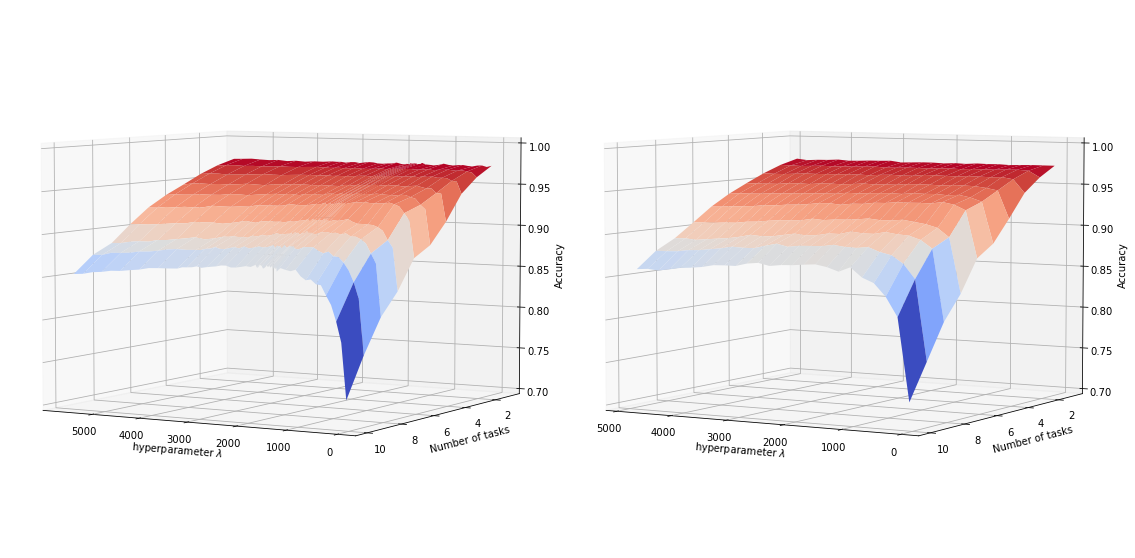

In [7]:
fig = plt.figure(figsize=(37, 10)) # (21.25, 5)
ax1 = fig.add_subplot(111, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
x1 = sorted(list(data1.keys()))
y1 = list(range(1, 11))
X1, Y1 = np.meshgrid(x1, y1)
zs1 = np.array(func1(np.ravel(X1), np.ravel(Y1)))
Z1 = zs1.reshape(X1.shape)
ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm)
ax1.set_xlabel(lambda_s)
ax1.set_ylabel(num_tasks)
ax1.set_zlabel(acc_s)
ax1.set_zlim(0.7, 1.)
ax1.view_init(5, 120)

x2 = sorted(list(data2.keys()))
y2 = list(range(1, 11))
X2, Y2 = np.meshgrid(x2, y2)
zs2 = np.array(func2(np.ravel(X2), np.ravel(Y2)))
Z2 = zs2.reshape(X2.shape)
ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm)
ax2.set_xlabel(lambda_s)
ax2.set_ylabel(num_tasks)
ax2.set_zlabel(acc_s)
ax2.set_zlim(0.7, 1.)
ax2.view_init(5, 120)

plt.savefig('surf3eng.png', dpi = 600)

plt.show()

**2. Сравним простейший градиентный спуск с Adam при ослаблении на градиентах и на изменениях весов.**

**И найдем $\lambda$, на котором достигается максимум точности.**

In [8]:
data1 = joblib.load('wva-sgd-1x-grads.dmp')
data2 = joblib.load('wva-adam-1x-grads.dmp')
data3 = joblib.load('wva-adam-1x-deltas.dmp')

In [9]:
l1 = sorted(list(data2.keys()))
means1 = np.asarray([np.mean(data2[l], axis=0)[9] for l in l1])
l2 = sorted(list(data3.keys()))
means2 = np.asarray([np.mean(data3[l], axis=0)[9] for l in l2])
n1, n2 = np.argmax(means1), np.argmax(means2)
l1_max, l2_max = l1[n1], l2[n2]
print(f'Using Adam-WVA (grads attenuation)  max mean accuracy {means1[n1]:0.5f} reached with lambda={l1_max}')
print(f'Using Adam-WVA (deltas attenuation) max mean accuracy {means2[n2]:0.5f} reached with lambda={l2_max}')
#l1_max, l2_max = 1250., 1650.

Using Adam-WVA (grads attenuation)  max mean accuracy 0.40732 reached with lambda=3450.0
Using Adam-WVA (deltas attenuation) max mean accuracy 0.84083 reached with lambda=1285.0


In [10]:
means1 = np.mean(data2[l1_max], axis=0)
intervals1 = np.std(data2[l1_max], axis=0) * 2.2622 / np.sqrt(10.)
means2 = np.mean(data3[l2_max], axis=0)
intervals2 = np.std(data3[l2_max], axis=0) * 2.2622 / np.sqrt(10.)

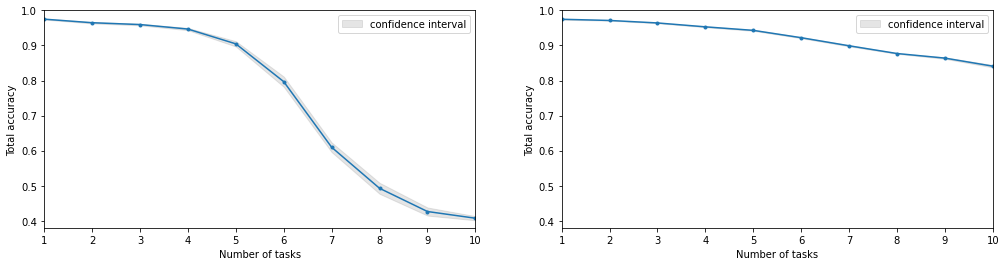

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))
x = np.arange(1, 11)
for ax, means, intervals in zip((ax1, ax2), (means1, means2), (intervals1, intervals2)):
    ax.set_ylim(0.38, 1.)
    ax.set_xlim(min(x), max(x))
    ax.set_ylabel(tot_acc)
    ax.set_xlabel(num_tasks)
    ax.fill_between(x, means-intervals, means+intervals, color='grey', alpha=.2, label=interval_s)
    ax.plot(x, means, marker=".")

# ax1.set_title(f'Accuracy degradation while learning on {len(means3)} tasks\n'
#               f'using Adam-WVA with gradients attenuations')
# ax2.set_title(f'Accuracy degradation while learning on {len(means2)} tasks\n'
#              f'using Adam-WVA with deltas attenuations')

#ax1.text(x = 7.2, y = 0.75, s = f'Adam-WVA\n''deltas attenuations')
#ax2.text(x = 7.2, y = 0.75, s = f'Adam-WVA\n''gradients attenuations')


ax1.legend()
ax2.legend()

plt.savefig('fig4eng.png', dpi = 600)

plt.show()

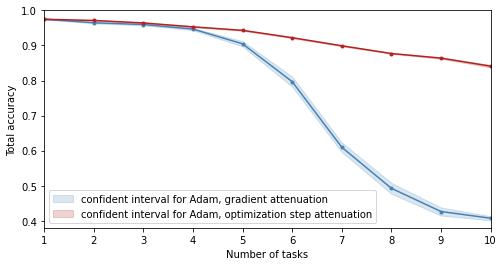

In [12]:
label1 = 'confident interval for Adam, gradient attenuation'
label2 = 'confident interval for Adam, optimization step attenuation'

means1 = np.mean(data2[l1_max], axis=0)
intervals1 = np.std(data2[l1_max], axis=0) * 2.2622 / np.sqrt(10.)
means2 = np.mean(data3[l2_max], axis=0)
intervals2 = np.std(data3[l2_max], axis=0) * 2.2622 / np.sqrt(10.)
x = np.arange(1, 11)

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(8, 4)
)
ax.set_ylim(0.38, 1.)
ax.set_xlim(min(x), max(x))
ax.set_ylabel(tot_acc)
ax.set_xlabel(num_tasks)
ax.fill_between(x, means1-intervals1, means1+intervals1, color='steelblue', alpha=.2, label=label1)
ax.plot(x, means1, color = 'steelblue', marker=".")
ax.fill_between(x, means2-intervals2, means2+intervals2, color='firebrick', alpha=.2, label=label2)
ax.plot(x, means2, color = 'firebrick', marker=".")
plt.legend()
# ax.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#                f'with lambda {lmbda} using SGD', fontsize = 18)
plt.savefig('fig4_single_eng.png', dpi = 600)
plt.show()

In [13]:
def func1(X, Y):
    return [np.mean(data2[l], axis=0)[n-1] for l, n in zip(X, Y)]

def func2(X, Y):
    return [np.mean(data3[l], axis=0)[n-1] for l, n in zip(X, Y)]

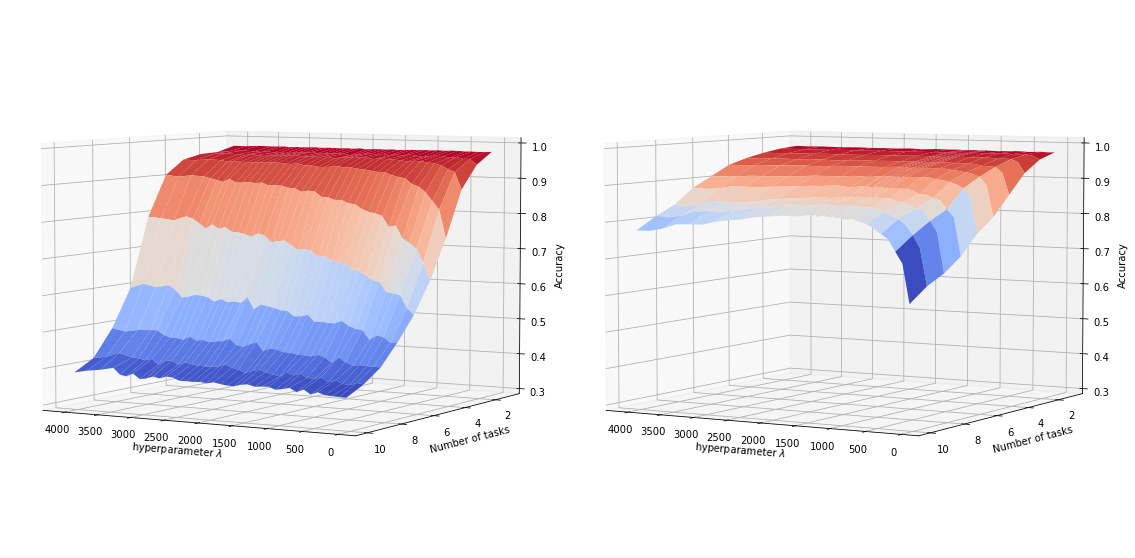

In [14]:
fig = plt.figure(figsize=(37, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x1 = sorted(list(data2.keys()))
y1 = list(range(1, 11))
X1, Y1 = np.meshgrid(x1, y1)
zs1 = np.array(func1(np.ravel(X1), np.ravel(Y1)))
Z1 = zs1.reshape(X1.shape)
ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm)
ax1.set_xlabel(lambda_s)
ax1.set_ylabel(num_tasks)
ax1.set_zlabel(acc_s)
ax1.set_zlim(0.3, 1.)
ax1.view_init(5, 120)

x2 = sorted(list(data3.keys()))
y2 = list(range(1, 11))
X2, Y2 = np.meshgrid(x2, y2)
zs2 = np.array(func2(np.ravel(X2), np.ravel(Y2)))
Z2 = zs2.reshape(X2.shape)
ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm)
ax2.set_xlabel(lambda_s)
ax2.set_ylabel(num_tasks)
ax2.set_zlabel(acc_s)
ax2.set_zlim(0.3, 1.)
ax2.view_init(5, 120)

plt.savefig('surf4eng.png', dpi = 600)

plt.show()

In [15]:
l1 = sorted(list(data1.keys()))
means1 = np.asarray([np.mean(data1[l], axis=0)[9] for l in l1])
intervals1 = np.asarray([np.std(data1[l], axis=0)[9] for l in l1]) * 2.2622 / np.sqrt(10.)

l2 = sorted(list(data2.keys()))
means2 = np.asarray([np.mean(data2[l], axis=0)[9] for l in l2])
intervals2 = np.asarray([np.std(data2[l], axis=0)[9] for l in l2]) * 2.2622 / np.sqrt(10.)

l3 = sorted(list(data3.keys()))
means3 = np.asarray([np.mean(data3[l], axis=0)[9] for l in l3])
intervals3 = np.asarray([np.std(data3[l], axis=0)[9] for l in l3]) * 2.2622 / np.sqrt(10.)

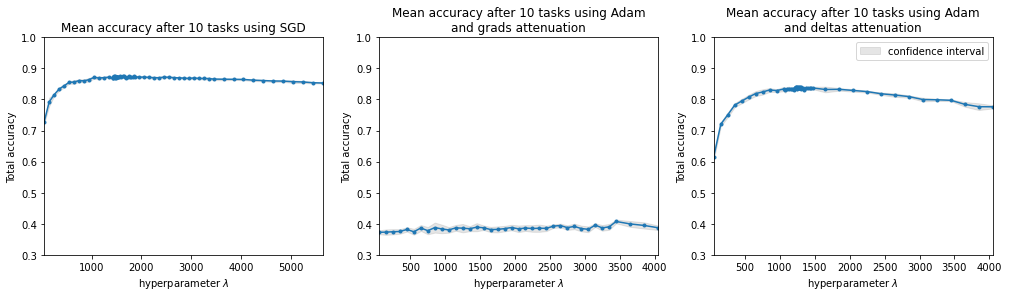

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3,
    figsize=(17, 4)
)
for ax, means, intervals, l in zip((ax1, ax2, ax3), (means1, means2, means3), (intervals1, intervals2, intervals3), (l1,l2,l3)):
    ax.set_ylim(0.3, 1.)
    ax.set_xlim(min(l), max(l))
    ax.set_ylabel(tot_acc)
    ax.set_xlabel(lambda_s)
    ax.fill_between(l, means-intervals, means+intervals, color='grey', alpha=.2, label=interval_s)
    ax.plot(l, means, marker=".")

ax1.set_title('Mean accuracy after 10 tasks using SGD')
ax2.set_title('Mean accuracy after 10 tasks using Adam\nand grads attenuation')
ax3.set_title('Mean accuracy after 10 tasks using Adam\nand deltas attenuation')
plt.legend()
plt.show()

In [17]:
n1, n2, n3 = np.argmax(means1), np.argmax(means2), np.argmax(means3)
print(f'Using SGD-WVA max mean accuracy {means1[n1]:0.5f} reached with lambda={l1[n1]}')
print(f'Using Adam-WVA (deltas attenuation) max mean accuracy {means2[n2]:0.5f} reached with lambda={l2[n2]}')
print(f'Using Adam-WVA (grads attenuation)  max mean accuracy {means3[n3]:0.5f} reached with lambda={l3[n3]}')

Using SGD-WVA max mean accuracy 0.87526 reached with lambda=1475.0
Using Adam-WVA (deltas attenuation) max mean accuracy 0.40732 reached with lambda=3450.0
Using Adam-WVA (grads attenuation)  max mean accuracy 0.84083 reached with lambda=1285.0


**3. Сравним использование функции WVA-трения веса $\frac{1}{1+\lambda x}$ против $e^{-\lambda x}$**

**3.1 Сначала для WVA-SGD**

In [39]:
data1 = joblib.load('wva-sgd-1x-grads.dmp')
data2 = joblib.load('wva-sgd-exp-grads.dmp')

In [40]:
l1 = sorted(list(data1.keys()))
means1 = np.asarray([np.mean(data1[l], axis=0)[9] for l in l1])
l2 = sorted(list(data2.keys()))
means2 = np.asarray([np.mean(data2[l], axis=0)[9] for l in l2])
n1, n2 = np.argmax(means1), np.argmax(means2)
l1_max, l2_max = l1[n1], l2[n2]
print(f'Using SGD-WVA 1/(x+1) attenuation)  max mean accuracy {means1[n1]:0.5f} reached with lambda={l1_max}')
print(f'Using SGD-WVA exp(-x) attenuation) max mean accuracy {means2[n2]:0.5f} reached with lambda={l2_max}')
#l1_max, l2_max = 1250., 1650.

Using SGD-WVA 1/(x+1) attenuation)  max mean accuracy 0.87526 reached with lambda=1475.0
Using SGD-WVA exp(-x) attenuation) max mean accuracy 0.87745 reached with lambda=143.0


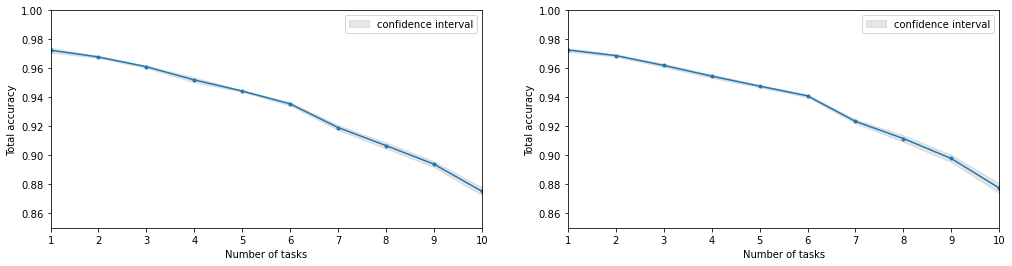

In [41]:
l1, l2 = l1_max, l2_max  # 1475., 143.
means1 = np.mean(data1[l1], axis=0)
intervals1 = np.std(data1[l1], axis=0) * 2.2622 / np.sqrt(10)
means2 = np.mean(data2[l2], axis=0)
intervals2 = np.std(data2[l2], axis=0) * 2.2622 / np.sqrt(10)
x = range(1, len(means1) + 1)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(17, 4)
)
for ax, means, intervals in zip((ax1, ax2), (means1, means2), (intervals1, intervals2)):
    ax.set_ylim(0.85, 1.)
    ax.set_xlim(min(x), max(x))
    ax.set_ylabel(tot_acc)
    ax.set_xlabel(num_tasks)
    ax.fill_between(x, means-intervals, means+intervals, color='grey', alpha=.2, label=interval_s)
    ax.plot(x, means, marker=".")
# ax1.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#               f'with lambda {l1} using SGD with 1/(1+lambda*x)')
# ax2.set_title(f'Mean accuracy degradation while continual learning on {len(means2)} datasets\n'
#               f'with lambda {l2} using SGD with exp(-lambda*x)')

ax1.legend()
ax2.legend()

#ax1.text(x = 7.2, y = 0.96, s = f'SGD, lambda {l1}\n''1/(1+lambda*x)')
#ax2.text(x = 7.2, y = 0.96, s = f'SGD, lambda {l2}\n''exp(-lambda*x)')

plt.savefig('fig5eng.png', dpi = 600)

plt.legend()
plt.show()

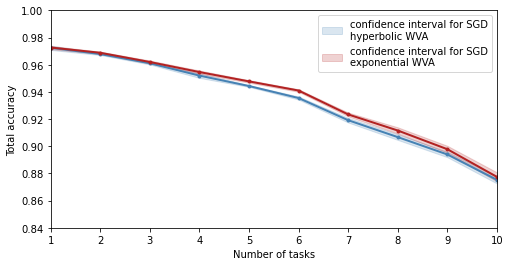

In [42]:
label1 = "confidence interval for SGD\nhyperbolic WVA"  # f'SGD, lambda {l1}\n''1/(1+lambda*x)'
label2 = "confidence interval for SGD\nexponential WVA"  # f'SGD, lambda {l1}\n''1/(1+lambda*x)'

l1, l2 = l1_max, l2_max  # 1475., 143.


means1 = np.mean(data1[l1], axis=0)
intervals1 = np.std(data1[l1], axis=0) * 2.2622 / np.sqrt(10)
means2 = np.mean(data2[l2], axis=0)
intervals2 = np.std(data2[l2], axis=0) * 2.2622 / np.sqrt(10)
x = range(1, len(means1) + 1)

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(8, 4)
)
ax.set_ylim(0.84, 1.)
ax.set_xlim(min(x), max(x))
ax.set_ylabel(tot_acc)
ax.set_xlabel(num_tasks)
ax.fill_between(x, means1-intervals1, means1+intervals1, color='steelblue', alpha=.2, label=label1)
ax.plot(x, means1, color = 'steelblue', marker=".", linewidth = 2)
ax.fill_between(x, means2-intervals2, means2+intervals2, color='firebrick', alpha=.2, label=label2)
ax.plot(x, means2, color = 'firebrick', marker=".", linewidth = 2)
plt.legend()
# ax.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#                f'with lambda {lmbda} using SGD', fontsize = 18)
plt.savefig('fig5_single_eng.png', dpi = 600)
plt.show()

In [43]:
data1 = joblib.load('wva-sgd-1x-grads.dmp')
data2 = joblib.load('wva-sgd-exp-grads.dmp')

def func1(X, Y):
    return [np.mean(data1[l], axis=0)[n-1] for l, n in zip(X, Y)]

def func2(X, Y):
    return [np.mean(data2[l], axis=0)[n-1] for l, n in zip(X, Y)]

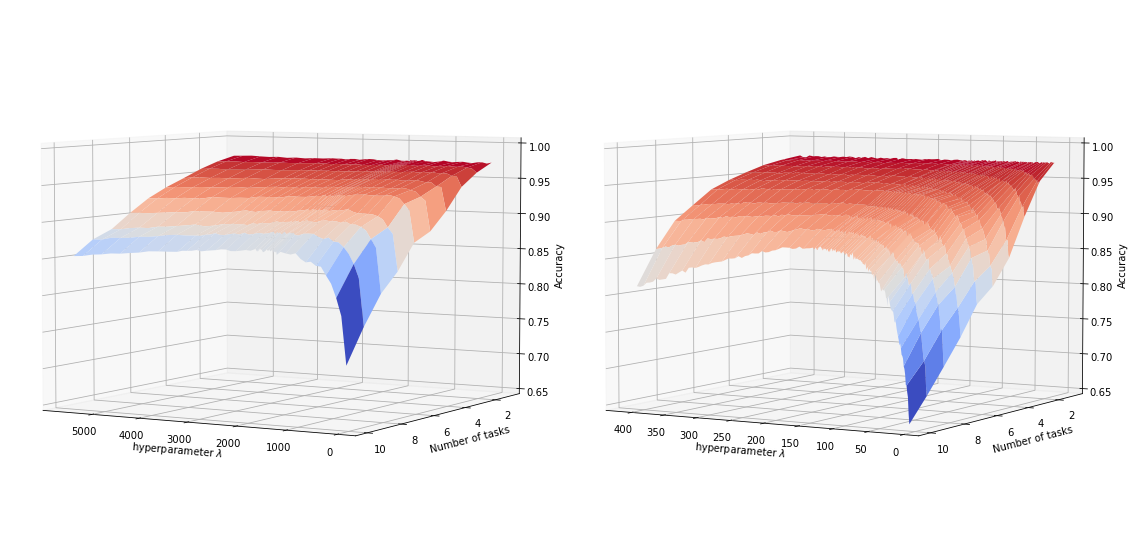

In [44]:
fig = plt.figure(figsize=(37, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
x1 = sorted(list(data1.keys()))
y1 = list(range(1, 11))
X1, Y1 = np.meshgrid(x1, y1)
zs1 = np.array(func1(np.ravel(X1), np.ravel(Y1)))
Z1 = zs1.reshape(X1.shape)
ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm)
ax1.set_xlabel(lambda_s)
ax1.set_ylabel(num_tasks)
ax1.set_zlabel(acc_s)
ax1.set_zlim(0.65, 1.)
ax1.view_init(5, 120)

x2 = sorted(list(data2.keys()))
y2 = list(range(1, 11))
X2, Y2 = np.meshgrid(x2, y2)
zs2 = np.array(func2(np.ravel(X2), np.ravel(Y2)))
Z2 = zs2.reshape(X2.shape)
ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm)
ax2.set_xlabel(lambda_s)
ax2.set_ylabel(num_tasks)
ax2.set_zlabel(acc_s)
ax2.set_zlim(0.65, 1.)
ax2.view_init(5, 120)

plt.savefig('surf5eng.png', dpi = 600)

plt.show()

In [45]:
l1 = sorted(list(data1.keys()))
l2 = sorted(list(data2.keys()))
for i in range(1, 10):
    means1 = np.asarray([np.mean(data1[l], axis=0)[i] for l in l1])
    n1 = np.argmax(means1)
    print(f'Using SGD-WVA with 1/(1+lambda*x) on {i+1} tasks max mean accuracy {means1[n1]:0.5f} reached on lambda={l1[n1]}')
print()
    
for i in range(1, 10):
    means2 = np.asarray([np.mean(data2[l], axis=0)[i] for l in l2])
    n2 = np.argmax(means2)
    print(f'Using SGD-WVA with exp(-lambda*x) on {i+1} tasks max mean accuracy {means2[n2]:0.5f} reached on lambda={l2[n2]}')

Using SGD-WVA with 1/(1+lambda*x) on 2 tasks max mean accuracy 0.96900 reached on lambda=1485.0
Using SGD-WVA with 1/(1+lambda*x) on 3 tasks max mean accuracy 0.96253 reached on lambda=1445.0
Using SGD-WVA with 1/(1+lambda*x) on 4 tasks max mean accuracy 0.95383 reached on lambda=1495.0
Using SGD-WVA with 1/(1+lambda*x) on 5 tasks max mean accuracy 0.94602 reached on lambda=1495.0
Using SGD-WVA with 1/(1+lambda*x) on 6 tasks max mean accuracy 0.93820 reached on lambda=550.0
Using SGD-WVA with 1/(1+lambda*x) on 7 tasks max mean accuracy 0.92047 reached on lambda=1050.0
Using SGD-WVA with 1/(1+lambda*x) on 8 tasks max mean accuracy 0.90882 reached on lambda=1525.0
Using SGD-WVA with 1/(1+lambda*x) on 9 tasks max mean accuracy 0.89483 reached on lambda=1625.0
Using SGD-WVA with 1/(1+lambda*x) on 10 tasks max mean accuracy 0.87526 reached on lambda=1475.0

Using SGD-WVA with exp(-lambda*x) on 2 tasks max mean accuracy 0.96950 reached on lambda=185.0
Using SGD-WVA with exp(-lambda*x) on 3 t

**3.2 Далее для WVA-Adam**

In [46]:
data1 = joblib.load('wva-adam-1x-deltas.dmp')
data2 = joblib.load('wva-adam-exp-deltas.dmp')

In [47]:
l1 = sorted(list(data1.keys()))
means1 = np.asarray([np.mean(data1[l], axis=0)[9] for l in l1])
l2 = sorted(list(data2.keys()))
means2 = np.asarray([np.mean(data2[l], axis=0)[9] for l in l2])
n1, n2 = np.argmax(means1), np.argmax(means2)
l1_max, l2_max = l1[n1], l2[n2]
print(f'Using Adam-WVA 1/(x+1) attenuation) max mean accuracy {means1[n1]:0.5f} reached with lambda={l1_max}')
print(f'Using Adam-WVA exp(-x) attenuation) max mean accuracy {means2[n2]:0.5f} reached with lambda={l2_max}')
#l1_max, l2_max = 1250., 114.

Using Adam-WVA 1/(x+1) attenuation) max mean accuracy 0.84083 reached with lambda=1285.0
Using Adam-WVA exp(-x) attenuation) max mean accuracy 0.82379 reached with lambda=114.0


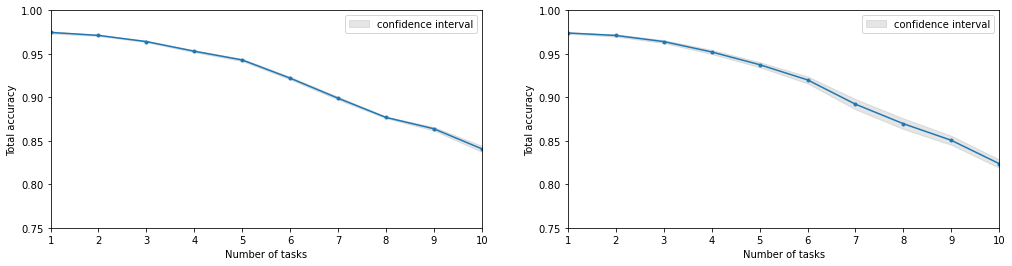

In [48]:
l1, l2 = l1_max, l2_max
means1 = np.mean(data1[l1], axis=0)
intervals1 = np.std(data1[l1], axis=0) * 2.2622 / np.sqrt(10)
means2 = np.mean(data2[l2], axis=0)
intervals2 = np.std(data2[l2], axis=0) * 2.2622 / np.sqrt(10)
x = range(1, len(means1) + 1)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(17, 4)
)
for ax, means, intervals in zip((ax1, ax2), (means1, means2), (intervals1, intervals2)):
    ax.set_ylim(0.75, 1.)
    ax.set_xlim(min(x), max(x))
    ax.set_ylabel(tot_acc)
    ax.set_xlabel(num_tasks)
    ax.fill_between(x, means-intervals, means+intervals, color='grey', alpha=.2, label=interval_s)
    ax.plot(x, means, marker=".")
# ax1.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#               f'with lambda {l1} using Adam with 1/(1+lambda*x)')
# ax2.set_title(f'Mean accuracy degradation while continual learning on {len(means2)} datasets\n'
#               f'with lambda {l2} using Adam with exp(-lambda*x)')

ax1.legend()
ax2.legend()

#ax1.text(x = 7.2, y = 0.94, s = f'Adam, lambda {l1}\n''1/(1+lambda*x)')
#ax2.text(x = 7.2, y = 0.94, s = f'Adam, lambda {l1}\n''exp(-lambda*x)')

plt.savefig('fig6eng.png', dpi = 600)

plt.legend()
plt.show()

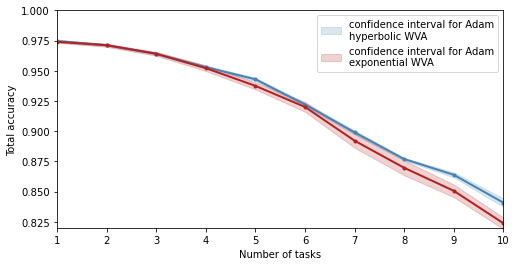

In [49]:
label1 = "confidence interval for Adam\nhyperbolic WVA"   # f'Adam, lambda {l1}\n''1/(1+lambda*x)'
label2 = "confidence interval for Adam\nexponential WVA"  # f'Adam, lambda {l1}\n''exp(-lambda*x)'

l1, l2 = l1_max, l2_max
means1 = np.mean(data1[l1], axis=0)
intervals1 = np.std(data1[l1], axis=0) * 2.2622 / np.sqrt(10)
means2 = np.mean(data2[l2], axis=0)
intervals2 = np.std(data2[l2], axis=0) * 2.2622 / np.sqrt(10)
x = range(1, len(means1) + 1)

fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(8, 4)
)
ax.set_ylim(0.82, 1.)
ax.set_xlim(min(x), max(x))
ax.set_ylabel(tot_acc)
ax.set_xlabel(num_tasks)
ax.fill_between(x, means1-intervals1, means1+intervals1, color='steelblue', alpha=.2, label=label1)
ax.plot(x, means1, color = 'steelblue', marker=".", linewidth = 2)
ax.fill_between(x, means2-intervals2, means2+intervals2, color='firebrick', alpha=.2, label=label2)
ax.plot(x, means2, color = 'firebrick', marker=".", linewidth = 2)
plt.legend()
# ax.set_title(f'Mean accuracy degradation while continual learning on {len(means1)} datasets\n'
#                f'with lambda {lmbda} using SGD', fontsize = 18)
plt.savefig('fig6_single_eng.png', dpi = 600)
plt.show()

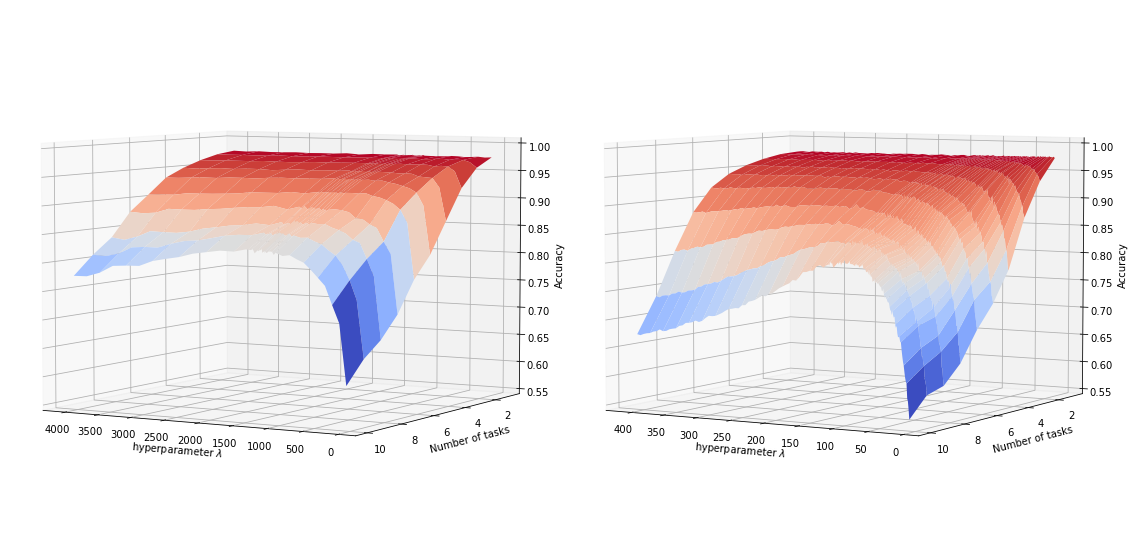

In [50]:
fig = plt.figure(figsize=(37, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
x1 = sorted(list(data1.keys()))
y1 = list(range(1, 11))
X1, Y1 = np.meshgrid(x1, y1)
zs1 = np.array(func1(np.ravel(X1), np.ravel(Y1)))
Z1 = zs1.reshape(X1.shape)
ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm)
ax1.set_xlabel(lambda_s)
ax1.set_ylabel(num_tasks)
ax1.set_zlabel(acc_s)
ax1.set_zlim(0.55, 1.)
ax1.view_init(5, 120)

x2 = sorted(list(data2.keys()))
y2 = list(range(1, 11))
X2, Y2 = np.meshgrid(x2, y2)
zs2 = np.array(func2(np.ravel(X2), np.ravel(Y2)))
Z2 = zs2.reshape(X2.shape)
ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm)
ax2.set_xlabel(lambda_s)
ax2.set_ylabel(num_tasks)
ax2.set_zlabel(acc_s)
ax2.set_zlim(0.55, 1.)
ax2.view_init(5, 120)

plt.savefig('surf6eng.png', dpi = 600)

plt.show()

In [51]:
l1 = sorted(list(data1.keys()))
l2 = sorted(list(data2.keys()))
for i in range(1, 10):
    means1 = np.asarray([np.mean(data1[l], axis=0)[i] for l in l1])
    n1 = np.argmax(means1)
    print(f'Using Adam-WVA with 1/(1+lambda*x) on {i+1} tasks max mean accuracy {means1[n1]:0.5f} reached on lambda={l1[n1]}')
print()
for i in range(1, 10):
    means2 = np.asarray([np.mean(data2[l], axis=0)[i] for l in l2])
    n2 = np.argmax(means2)
    print(f'Using Adam-WVA with exp(-lambda*x) on {i+1} tasks max mean accuracy {means2[n2]:0.5f} reached on lambda={l2[n2]}')

Using Adam-WVA with 1/(1+lambda*x) on 2 tasks max mean accuracy 0.97256 reached on lambda=550.0
Using Adam-WVA with 1/(1+lambda*x) on 3 tasks max mean accuracy 0.96502 reached on lambda=950.0
Using Adam-WVA with 1/(1+lambda*x) on 4 tasks max mean accuracy 0.95408 reached on lambda=1260.0
Using Adam-WVA with 1/(1+lambda*x) on 5 tasks max mean accuracy 0.94386 reached on lambda=1235.0
Using Adam-WVA with 1/(1+lambda*x) on 6 tasks max mean accuracy 0.92356 reached on lambda=1245.0
Using Adam-WVA with 1/(1+lambda*x) on 7 tasks max mean accuracy 0.90073 reached on lambda=1400.0
Using Adam-WVA with 1/(1+lambda*x) on 8 tasks max mean accuracy 0.87909 reached on lambda=1280.0
Using Adam-WVA with 1/(1+lambda*x) on 9 tasks max mean accuracy 0.86454 reached on lambda=1295.0
Using Adam-WVA with 1/(1+lambda*x) on 10 tasks max mean accuracy 0.84083 reached on lambda=1285.0

Using Adam-WVA with exp(-lambda*x) on 2 tasks max mean accuracy 0.97164 reached on lambda=145.0
Using Adam-WVA with exp(-lambda

**4. Теперь сравним различные способы расчета важности весов**

**4.1 Сначала для WVA-SGD**

In [52]:
data1 = joblib.load('wva-sgd-1x-grads.dmp')
data2 = joblib.load('wvaMAS-sgd-1x-grads.dmp')
data3 = joblib.load('wvaFIS-sgd-1x-grads.dmp')
def func1(X, Y):
    return [np.mean(data1[l], axis=0)[n-1] for l, n in zip(X, Y)]
def func2(X, Y):
    return [np.mean(data2[l], axis=0)[n-1] for l, n in zip(X, Y)]
def func3(X, Y):
    return [np.mean(data3[l], axis=0)[n-1] for l, n in zip(X, Y)]

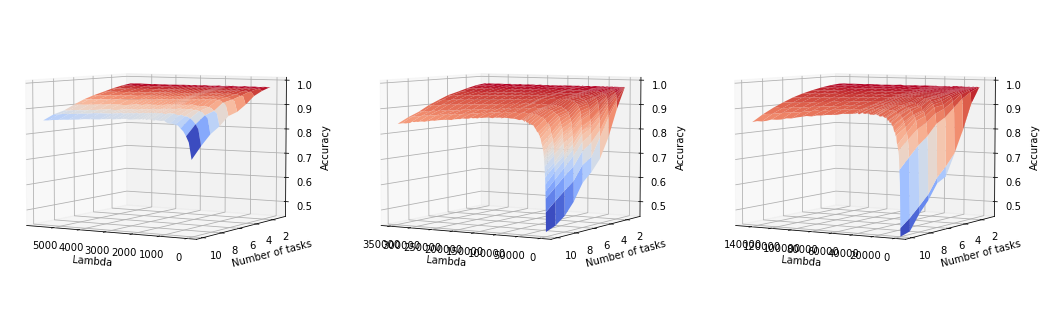

In [130]:
fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
x1 = sorted(list(data1.keys()))
y1 = list(range(1, 11))
X1, Y1 = np.meshgrid(x1, y1)
zs1 = np.array(func1(np.ravel(X1), np.ravel(Y1)))
Z1 = zs1.reshape(X1.shape)
ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm)
ax1.set_xlabel('Lambda')
ax1.set_ylabel(num_tasks)
ax1.set_zlabel('Accuracy')
ax1.set_zlim(0.45, 1.)
ax1.view_init(5, 120)

x2 = sorted(list(data2.keys()))
y2 = list(range(1, 11))
X2, Y2 = np.meshgrid(x2, y2)
zs2 = np.array(func2(np.ravel(X2), np.ravel(Y2)))
Z2 = zs2.reshape(X2.shape)
ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm)
ax2.set_xlabel('Lambda')
ax2.set_ylabel(num_tasks)
ax2.set_zlabel('Accuracy')
ax2.set_zlim(0.45, 1.)
ax2.view_init(5, 120)

x3 = sorted(list(data3.keys()))
y3 = list(range(1, 11))
X3, Y3 = np.meshgrid(x3, y3)
zs3 = np.array(func3(np.ravel(X3), np.ravel(Y3)))
Z3 = zs3.reshape(X3.shape)
ax3.plot_surface(X3, Y3, Z3, cmap=cm.coolwarm)
ax3.set_xlabel('Lambda')
ax3.set_ylabel(num_tasks)
ax3.set_zlabel('Accuracy')
ax3.set_zlim(0.45, 1.)
ax3.view_init(5, 120)

plt.show()

In [131]:
l1 = sorted(list(data1.keys()))
l2 = sorted(list(data2.keys()))
l3 = sorted(list(data3.keys()))
for i in range(1, 10):
    means1 = np.asarray([np.mean(data1[l], axis=0)[i] for l in l1])
    n1 = np.argmax(means1)
    print(f'Using SGD-WVA-SIG on {i+1} tasks max mean accuracy {means1[n1]:0.5f} reached on lambda={l1[n1]}')
print()
for i in range(1, 10):
    means2 = np.asarray([np.mean(data2[l], axis=0)[i] for l in l2])
    n2 = np.argmax(means2)
    print(f'Using SGD-WVA-MAS on {i+1} tasks max mean accuracy {means2[n2]:0.5f} reached on lambda={l2[n2]}')
print()
for i in range(1, 10):
    means3 = np.asarray([np.mean(data3[l], axis=0)[i] for l in l3])
    n3 = np.argmax(means3)
    print(f'Using SGD-WVA-FIS on {i+1} tasks max mean accuracy {means3[n3]:0.5f} reached on lambda={l3[n3]}')

Using SGD-WVA-SIG on 2 tasks max mean accuracy 0.96900 reached on lambda=1485.0
Using SGD-WVA-SIG on 3 tasks max mean accuracy 0.96253 reached on lambda=1445.0
Using SGD-WVA-SIG on 4 tasks max mean accuracy 0.95383 reached on lambda=1495.0
Using SGD-WVA-SIG on 5 tasks max mean accuracy 0.94602 reached on lambda=1495.0
Using SGD-WVA-SIG on 6 tasks max mean accuracy 0.93820 reached on lambda=550.0
Using SGD-WVA-SIG on 7 tasks max mean accuracy 0.92047 reached on lambda=1050.0
Using SGD-WVA-SIG on 8 tasks max mean accuracy 0.90882 reached on lambda=1525.0
Using SGD-WVA-SIG on 9 tasks max mean accuracy 0.89483 reached on lambda=1625.0
Using SGD-WVA-SIG on 10 tasks max mean accuracy 0.87526 reached on lambda=1475.0

Using SGD-WVA-MAS on 2 tasks max mean accuracy 0.96925 reached on lambda=75050.0
Using SGD-WVA-MAS on 3 tasks max mean accuracy 0.96318 reached on lambda=50050.0
Using SGD-WVA-MAS on 4 tasks max mean accuracy 0.95437 reached on lambda=51800.0
Using SGD-WVA-MAS on 5 tasks max mea

**4.2 Далее для WVA-Adam**

In [132]:
data1 = joblib.load('wva-adam-1x-deltas.dmp')
data2 = joblib.load('wvaMAS-adam-1x-deltas.dmp')
data3 = joblib.load('wvaFIS-adam-1x-deltas.dmp')
def func1(X, Y):
    return [np.mean(data1[l], axis=0)[n-1] for l, n in zip(X, Y)]
def func2(X, Y):
    return [np.mean(data2[l], axis=0)[n-1] for l, n in zip(X, Y)]
def func3(X, Y):
    return [np.mean(data3[l], axis=0)[n-1] for l, n in zip(X, Y)]

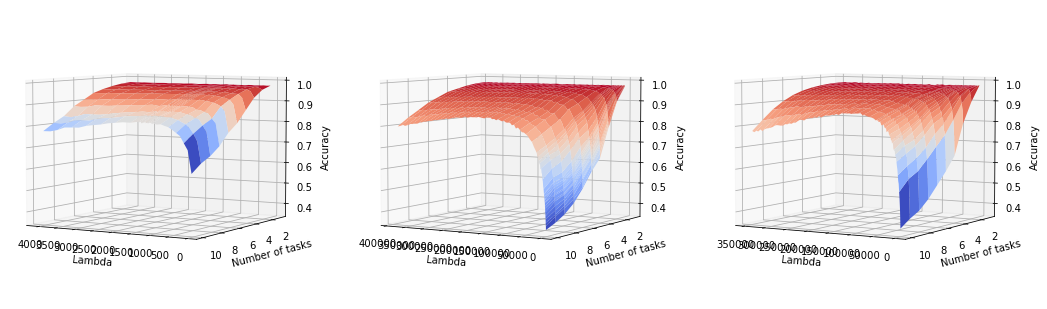

In [133]:
fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
x1 = sorted(list(data1.keys()))
y1 = list(range(1, 11))
X1, Y1 = np.meshgrid(x1, y1)
zs1 = np.array(func1(np.ravel(X1), np.ravel(Y1)))
Z1 = zs1.reshape(X1.shape)
ax1.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm)
ax1.set_xlabel('Lambda')
ax1.set_ylabel(num_tasks)
ax1.set_zlabel('Accuracy')
ax1.set_zlim(0.35, 1.)
ax1.view_init(5, 120)

x2 = sorted(list(data2.keys()))
y2 = list(range(1, 11))
X2, Y2 = np.meshgrid(x2, y2)
zs2 = np.array(func2(np.ravel(X2), np.ravel(Y2)))
Z2 = zs2.reshape(X2.shape)
ax2.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm)
ax2.set_xlabel('Lambda')
ax2.set_ylabel(num_tasks)
ax2.set_zlabel('Accuracy')
ax2.set_zlim(0.35, 1.)
ax2.view_init(5, 120)

x3 = sorted(list(data3.keys()))
y3 = list(range(1, 11))
X3, Y3 = np.meshgrid(x3, y3)
zs3 = np.array(func3(np.ravel(X3), np.ravel(Y3)))
Z3 = zs3.reshape(X3.shape)
ax3.plot_surface(X3, Y3, Z3, cmap=cm.coolwarm)
ax3.set_xlabel('Lambda')
ax3.set_ylabel(num_tasks)
ax3.set_zlabel('Accuracy')
ax3.set_zlim(0.35, 1.)
ax3.view_init(5, 120)

plt.show()

In [134]:
l1 = sorted(list(data1.keys()))
l2 = sorted(list(data2.keys()))
l3 = sorted(list(data3.keys()))
for i in range(1, 10):
    means1 = np.asarray([np.mean(data1[l], axis=0)[i] for l in l1])
    n1 = np.argmax(means1)
    print(f'Using Adam-WVA-SIG on {i+1} tasks max mean accuracy {means1[n1]:0.5f} reached on lambda={l1[n1]}')
print()
for i in range(1, 10):
    means2 = np.asarray([np.mean(data2[l], axis=0)[i] for l in l2])
    n2 = np.argmax(means2)
    print(f'Using Adam-WVA-MAS on {i+1} tasks max mean accuracy {means2[n2]:0.5f} reached on lambda={l2[n2]}')
print()
for i in range(1, 10):
    means3 = np.asarray([np.mean(data3[l], axis=0)[i] for l in l3])
    n3 = np.argmax(means3)
    print(f'Using Adam-WVA-FIS on {i+1} tasks max mean accuracy {means3[n3]:0.5f} reached on lambda={l3[n3]}')

Using Adam-WVA-SIG on 2 tasks max mean accuracy 0.97256 reached on lambda=550.0
Using Adam-WVA-SIG on 3 tasks max mean accuracy 0.96502 reached on lambda=950.0
Using Adam-WVA-SIG on 4 tasks max mean accuracy 0.95408 reached on lambda=1260.0
Using Adam-WVA-SIG on 5 tasks max mean accuracy 0.94386 reached on lambda=1235.0
Using Adam-WVA-SIG on 6 tasks max mean accuracy 0.92356 reached on lambda=1245.0
Using Adam-WVA-SIG on 7 tasks max mean accuracy 0.90073 reached on lambda=1400.0
Using Adam-WVA-SIG on 8 tasks max mean accuracy 0.87909 reached on lambda=1280.0
Using Adam-WVA-SIG on 9 tasks max mean accuracy 0.86454 reached on lambda=1295.0
Using Adam-WVA-SIG on 10 tasks max mean accuracy 0.84083 reached on lambda=1285.0

Using Adam-WVA-MAS on 2 tasks max mean accuracy 0.97248 reached on lambda=185050.0
Using Adam-WVA-MAS on 3 tasks max mean accuracy 0.96578 reached on lambda=185050.0
Using Adam-WVA-MAS on 4 tasks max mean accuracy 0.95564 reached on lambda=230050.0
Using Adam-WVA-MAS on 